# Prototype 2 > Experiment 3

## --- Dependencies ---

In [3]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time
import torch
from tabulate import tabulate

In [4]:
# Global Dependencies
from src.custom_types import Behavior, MTDTechnique, Execution, Evaluation
from src.data_provider import DataProvider
from src.functions import split_training_data, split_data

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from src.environment import Environment
from src.deep_q_network import DeepQNetwork
from src.agent import Agent
from src.client import Client
from src.server import Server
from src.experiment import Experiment
from src.autoencoder import AutoEncoder, RMSELoss

In [10]:
training_data, test_data, _ = DataProvider.get_scaled_train_test_split(pi=3, scaling_minmax=True,
                                                                         scale_normal_only=True)
normal_data = training_data[Behavior.NORMAL]
threshold = int(len(normal_data) * 0.5)

training_data[Behavior.NORMAL] = normal_data[:threshold]

ae_training_data = normal_data[threshold:]  # use remaining samples for autoencoder
ae_training_x, ae_valid_x = split_data(ae_training_data)

flattend_test_data = np.empty([0,47])
for behavior, behavior_data in test_data.items():
    if behavior == Behavior.NORMAL:
        NR_SAMPLES = 2800
        behavior_data[:, -1] =  0
    else:
        NR_SAMPLES = 400
        behavior_data[:, -1] = 1
    #y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * NR_SAMPLES)
    
    flattend_test_data = np.concatenate((flattend_test_data, behavior_data[:NR_SAMPLES]), axis=0)

ae_test_x = flattend_test_data[:,:-1]
ae_test_y = flattend_test_data[:,-1].astype(int)

evaluation_data = {}
for behavior, behavior_data in training_data.items():
    if behavior == Behavior.NORMAL:
        evaluation_data[behavior] = behavior_data[:2800]
    else:
        evaluation_data[behavior] = behavior_data[:400]

In [12]:
autoencoder = AutoEncoder(initial_autoencoder_architecture(), ae_valid_x, ae_test_x, ae_test_y, evaluation_data)
autoencoder.pretrain(ae_training_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=100, batch_size=64, verbose=False)
autoencoder.evaluate(num_std=2, tablefmt='latex_raw')

-----------
\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   \#Samples \\
\hline
 NORMAL                   & 84.39\%    & \notCalculated & \notCalculated & \notCalculated &        2800 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &         400 \\
 ROOTKIT\_BEURK           & 38.50\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_THETICK             & 42.25\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_BACKDOOR\_JAKORITAR & 37.00\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT1                & 99.25\%    & \notCalculated & \notCalculated & \notCalculated &         400 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &   

In [39]:
rl_training_data, rl_test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)
rl_test_data_dict = get_test_dataset(rl_test_data)

In [52]:
training_data_strides = split_training_data(rl_training_data, 10)

---
## Scenario 05 (Weak Client Exclusive Class Setting)

In [49]:
e1v5 = run_sample_distribution_experiment(rl_training_data_strides, weak_client_exclusive_sampling_probabilities_01, weak_client_exclusive_sampling_probabilities_02, 10, 30, 100, False)

0.0004166666666666667
Dataset Balance Metrics: MID=0.0198 & WCS=0.9574
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=4, bias=True)
  (loss): MSELoss()
)
=== STARTING EXPERIMENT 1.5 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |       0    | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |     

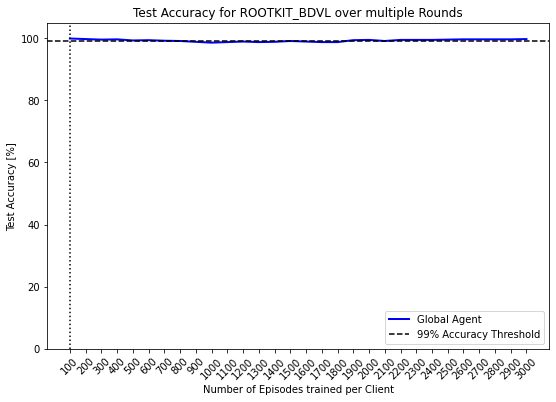

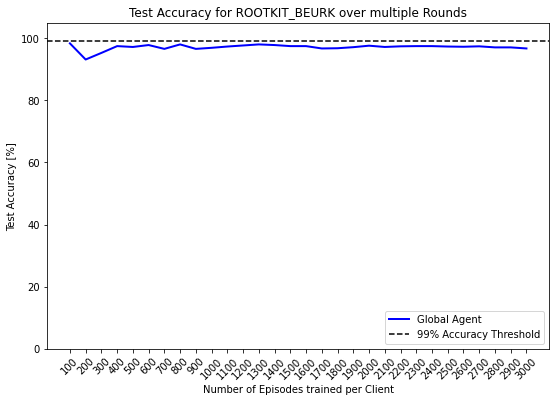

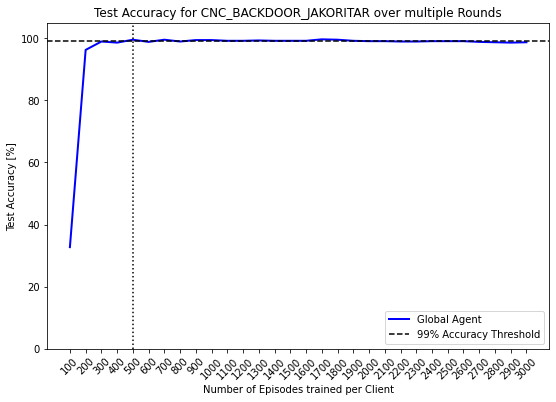

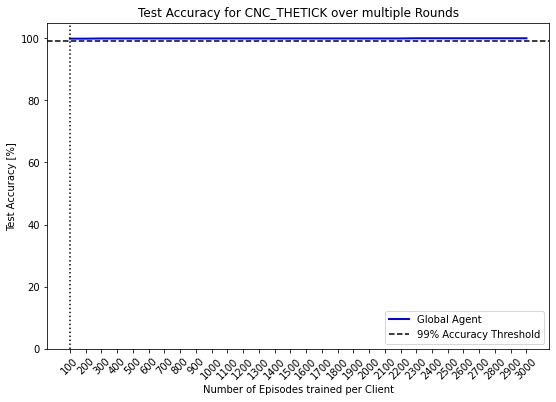

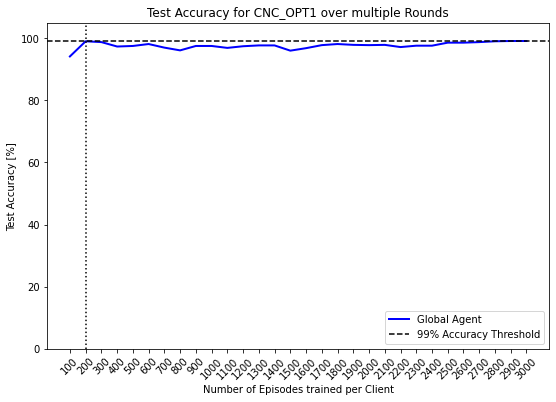

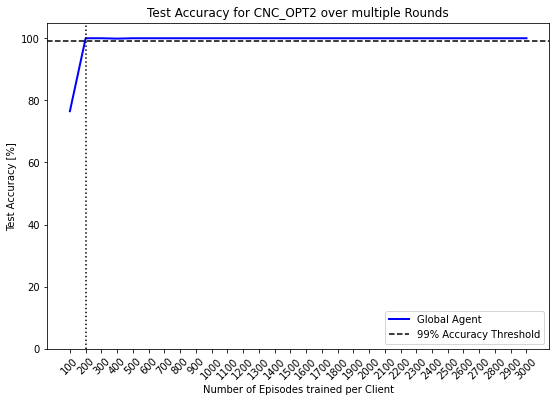

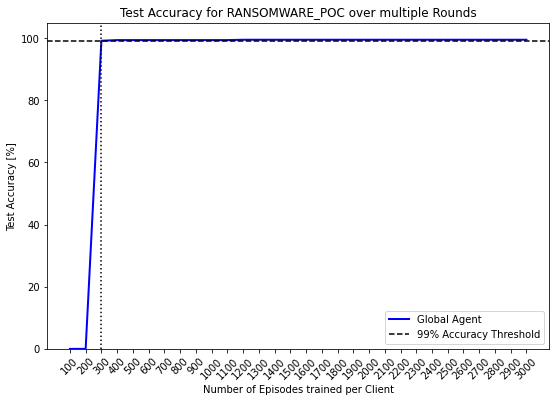

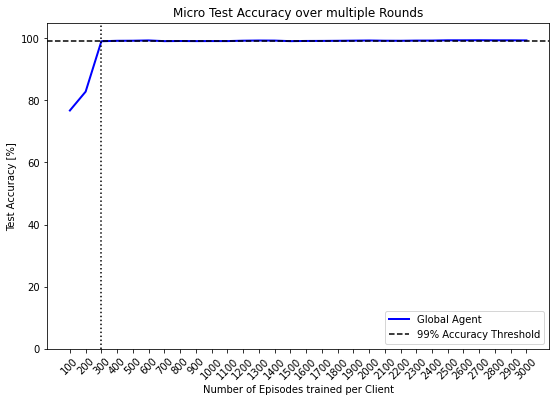

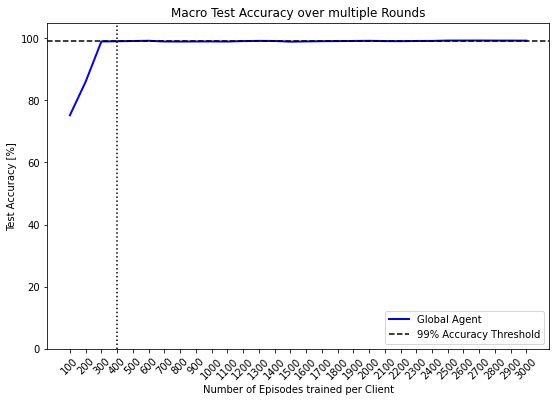

In [75]:
e1v5.show_experiment_graphs(y_threshold=99, show_individual_clients=False)

---
## Scenario 06 (Medium Client Exclusive Class Setting)

In [46]:
e1v6 = run_sample_distribution_experiment(rl_training_data_strides, medium_client_exclusive_sampling_probabilities_01, medium_client_exclusive_sampling_probabilities_02, 10, 30, 100, False)

0.0004166666666666667
Dataset Balance Metrics: MID=0.0304 & WCS=0.8944
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=4, bias=True)
  (loss): MSELoss()
)
=== STARTING EXPERIMENT 1.6 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |       0    | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |     

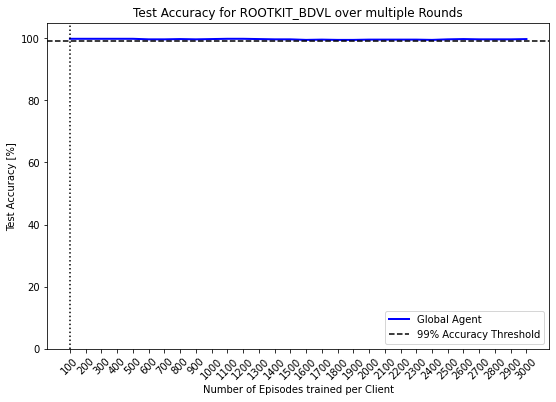

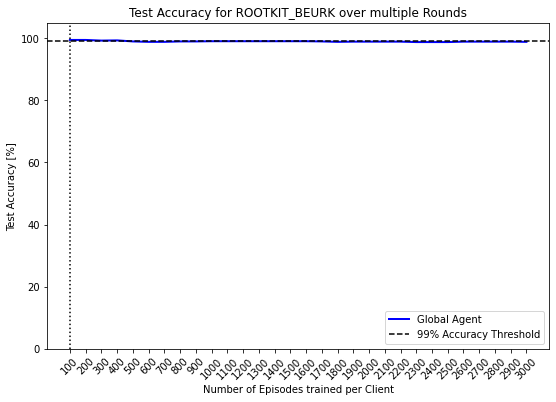

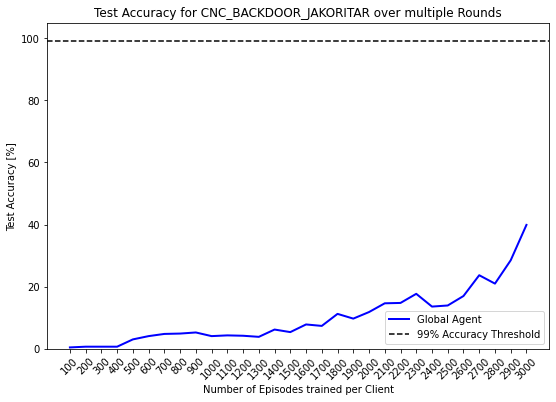

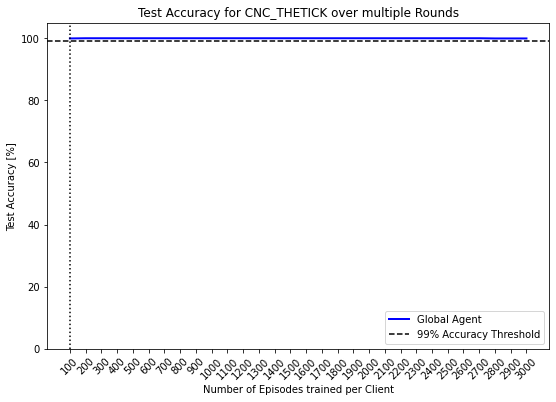

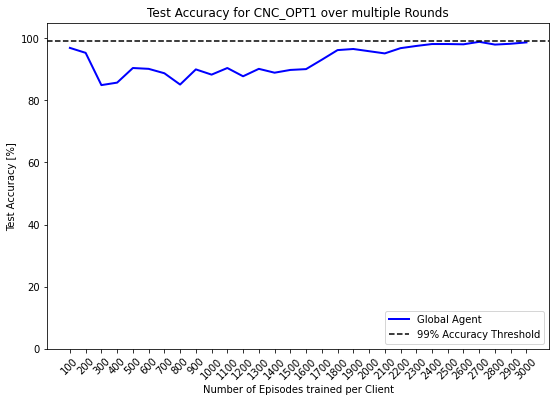

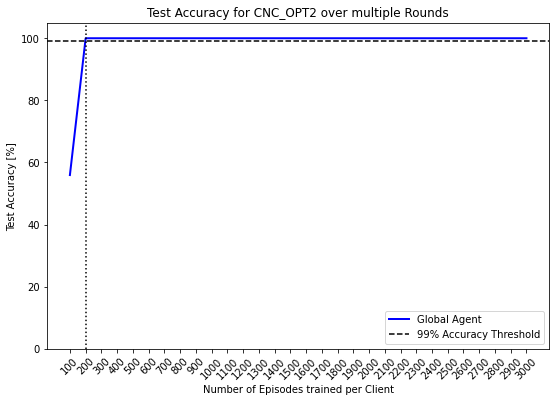

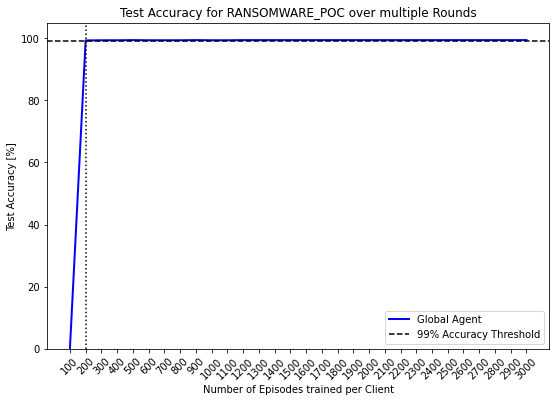

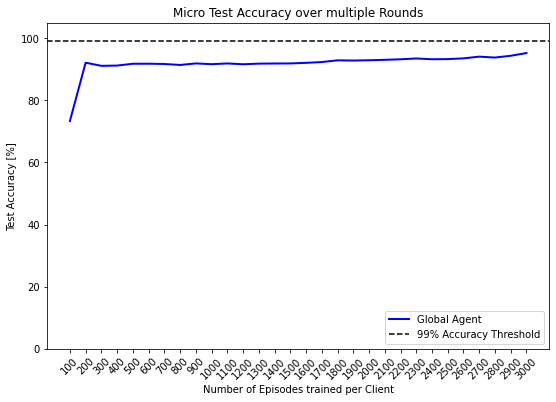

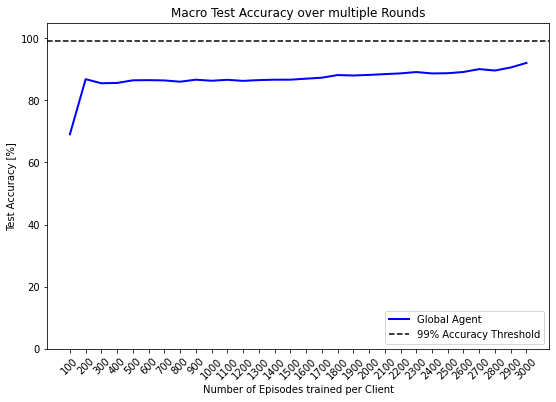

In [76]:
e1v6.show_experiment_graphs(y_threshold=99, show_individual_clients=False)

---
## Scenario 07 (Strong Client Exclusive Class Setting)

In [43]:
e1v7 = run_sample_distribution_experiment(rl_training_data_strides, strong_client_exclusive_sampling_probabilities_01, strong_client_exclusive_sampling_probabilities_02, 10, 30, 100, False)

0.0004166666666666667
Dataset Balance Metrics: MID=0.0053 & WCS=0.7053
DeepQNetwork(
  (L1): Linear(in_features=86, out_features=128, bias=True)
  (L2): Linear(in_features=128, out_features=128, bias=True)
  (L3): Linear(in_features=128, out_features=16, bias=True)
  (L4): Linear(in_features=128, out_features=4, bias=True)
  (loss): MSELoss()
)
=== STARTING EXPERIMENT 1.7 ===

Training each of the 10 clients for a total of 3000 episodes distributed over 30 rounds with 100 episodes per round.
>>> SERVER TRAINING ROUND 1/30 <<<
Evaluating round 1/30
Global Agent > Performance Evaluation
| Behavior                        |   Accuracy | Objective                             |   Nr. Samples |
|:--------------------------------|-----------:|:--------------------------------------|--------------:|
| Behavior.NORMAL                 |     100    | MTDTechnique.CONTINUE                 |          2930 |
| Behavior.RANSOMWARE_POC         |      99.3  | MTDTechnique.RANSOMWARE_FILE_EXT_HIDE |     

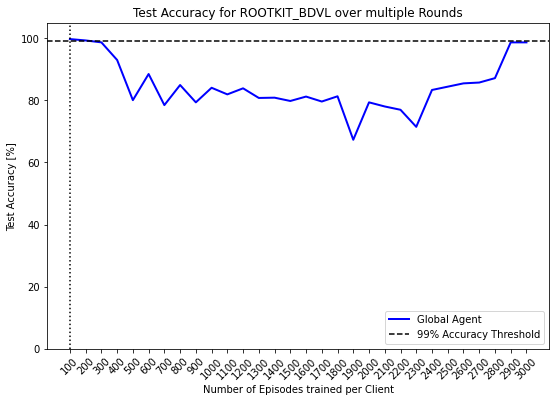

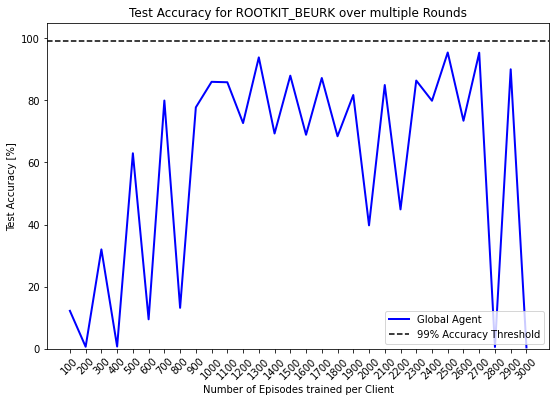

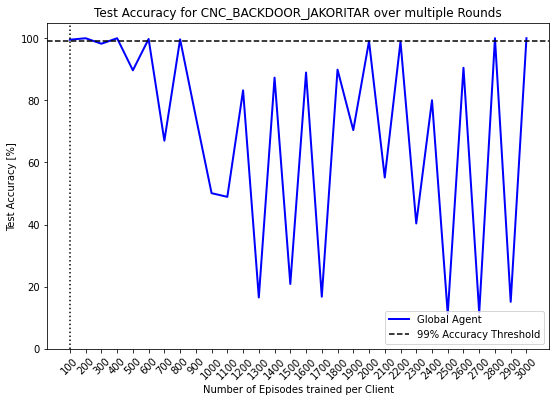

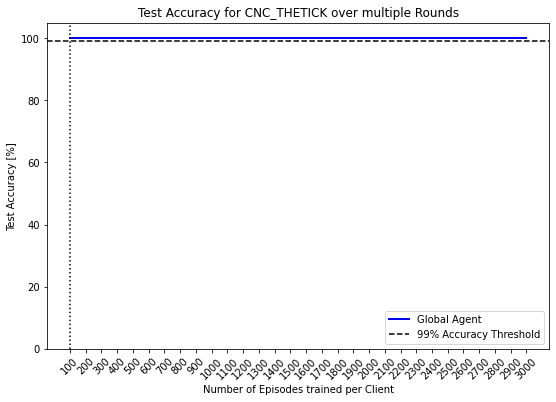

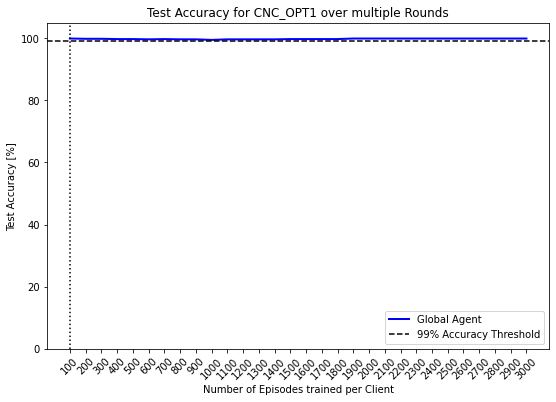

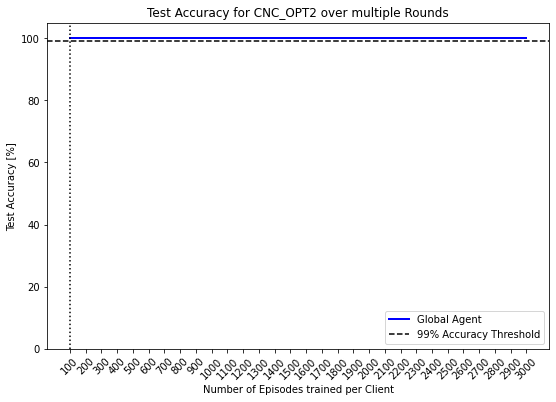

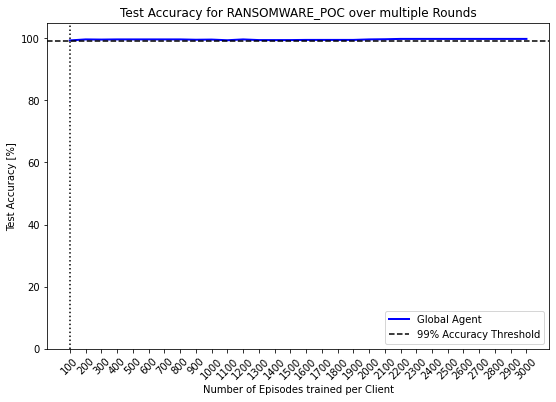

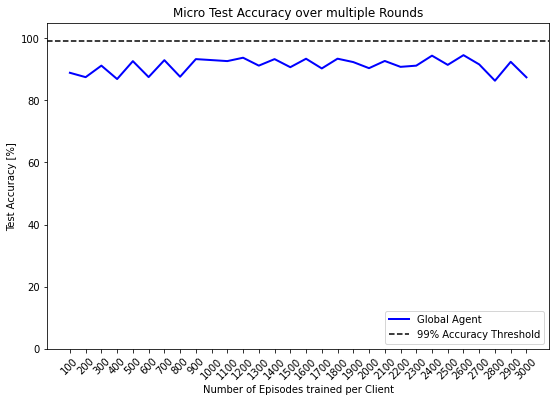

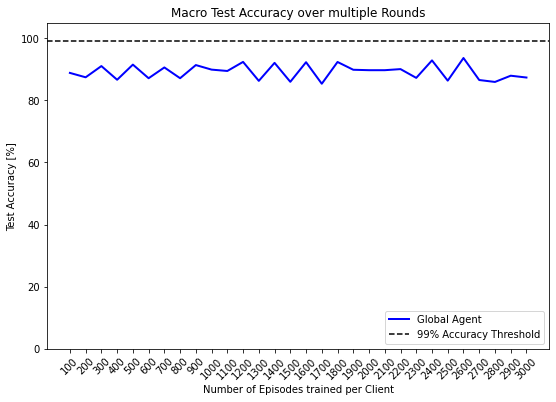

In [78]:
e1v7.show_experiment_graphs(y_threshold=99, show_individual_clients=False)